In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6


import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar
from utils import get_dataset, average_weights, exp_details

In [2]:
import argparse

parser = argparse.ArgumentParser()
# parser.add_argument('--name', '-n', default='foo', help='foo')
parser.add_argument('--model', type=str, default='mlp', help='model name(mlp or cnn)')
parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset(mnist or cifar)")
parser.add_argument('--epochs', type=int, default=5, help="number of rounds of training(10)")
parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
parser.add_argument('--gpu', default=None, help="To use cuda, set to a specific GPU ID. Default set to use CPU.")
parser.add_argument('--frac', type=float, default=0.1, help='the fraction of clients: C')
parser.add_argument('--local_ep', type=int, default=5, help="the number of local epochs: E")
parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--optimizer', type=str, default='sgd', help="type of optimizer")
parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--iid', type=int, default=1, help='Default set to IID. Set to 0 for non-IID.')
parser.add_argument('--unequal', type=int, default=0, help='whether to use unequal data splits for  \
                        non-i.i.d setting (use 0 for equal splits)')
# parser.add_argument('--seed', type=int, default=1, help='random seed')

parser.add_argument('--num_clusters', type=int, default=2, help='verbose')


# args = parser.parse_args([])
args, _ = parser.parse_known_args()

args
# --dataset=mnist --gpu=0 --iid=0 --epochs=10

Namespace(dataset='mnist', epochs=5, frac=0.1, gpu=None, iid=1, local_bs=10, local_ep=5, lr=0.01, model='mlp', num_classes=10, num_clusters=2, num_users=100, optimizer='sgd', unequal=0, verbose=1)

In [7]:
# if __name__ == '__main__':
start_time = time.time()
print("start time: ", start_time)

# define paths
path_project = os.path.abspath('..')
logger = SummaryWriter('../logs')

# args = args_parser()
# exp_details(args)

start time:  1571372605.758036


In [8]:
if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [9]:
# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

In [10]:
# Splitting into clusters. FL groups
cluster_size = args.num_users / args.num_clusters
print("Each cluster size: ", cluster_size)

# Cluster 1
A1 = np.arange(cluster_size, dtype=int)
user_groupsA = {k:user_groups[k] for k in A1 if k in user_groups}
print("Size of cluster 1: ", len(user_groupsA))
# Cluster 2
B1 = np.arange(cluster_size, cluster_size+cluster_size, dtype=int)
user_groupsB = {k:user_groups[k] for k in B1 if k in user_groups}
print("Size of cluster 2: ", len(user_groupsB))

Each cluster size:  50.0
Size of cluster 1:  50
Size of cluster 2:  50


In [11]:
# Check that clusters are all different
print(user_groupsA.keys())
print(user_groupsB.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [12]:
# BUILD MODEL
def build_model(args, train_dataset):
    if args.model == 'cnn':
        # Convolutional neural netork
        if args.dataset == 'mnist':
            global_model = CNNMnist(args=args)
        elif args.dataset == 'fmnist':
            global_model = CNNFashion_Mnist(args=args)
        elif args.dataset == 'cifar':
            global_model = CNNCifar(args=args)

    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=200,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')
        
    return global_model

In [13]:
# MODEL PARAM SUMMARY
global_model = build_model(args, train_dataset)
pytorch_total_params = sum(p.numel() for p in global_model.parameters())
print(pytorch_total_params)

from torchsummary import summary

summary(global_model, (1, 28, 28))
global_model.parameters()

199210
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
           Dropout-2                  [-1, 200]               0
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
           Dropout-5                  [-1, 200]               0
              ReLU-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
           Softmax-8                   [-1, 10]               0
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


<generator object Module.parameters at 0x7fd39fcdd570>

In [14]:
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=200, out_features=200, bias=True)
  (layer_hidden2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [15]:
# Set the cluster models to train and send it to device.
cluster_modelA = build_model(args, train_dataset)
cluster_modelA.to(device)
cluster_modelA.train()
# copy weights
cluster_modelA_weights = cluster_modelA.state_dict()

# Set the cluster models to train and send it to device.
cluster_modelB = build_model(args, train_dataset)
cluster_modelB.to(device)
cluster_modelB.train()
# copy weights
cluster_modelB_weights = cluster_modelA.state_dict()

In [16]:
# Defining the training function
def fl_train(args, train_dataset, cluster_global_model, cluster, usergrp, epochs):
#     print(args)
    
#     # Set the model to train and send it to device.
#     cluster_global_model = build_model(args, train_dataset)
#     cluster_global_model.to(device)
#     cluster_global_model.train()

#     # copy weights
#     cluster_global_weights = cluster_global_model.state_dict()
    
    cluster_train_loss, cluster_train_accuracy = [], []
    cluster_val_acc_list, cluster_net_list = [], []
    cluster_cv_loss, cluster_cv_acc = [], []
    print_every = 2
    cluster_val_loss_pre, counter = 0, 0

    for epoch in tqdm(range(epochs)):
        cluster_local_weights, cluster_local_losses = [], []
        print(f'\n | Cluster Training Round : {epoch+1} |\n')

        cluster_global_model.train()
        m = max(int(args.frac * len(cluster)), 1)
        idxs_users = np.random.choice(cluster, m, replace=False)


        for idx in idxs_users:
            cluster_local_model = LocalUpdate(args=args, dataset=train_dataset, idxs=usergrp[idx], logger=logger)
            cluster_w, cluster_loss = cluster_local_model.update_weights(model=copy.deepcopy(cluster_global_model), global_round=epoch)
            cluster_local_weights.append(copy.deepcopy(cluster_w))
            cluster_local_losses.append(copy.deepcopy(cluster_loss))

        # averaging global weights
        cluster_global_weights = average_weights(cluster_local_weights)

        # update global weights
        cluster_global_model.load_state_dict(cluster_global_weights)

        cluster_loss_avg = sum(cluster_local_losses) / len(cluster_local_losses)
        cluster_train_loss.append(cluster_loss_avg)

#         # Calculate avg training accuracy over all users at every epoch
#         cluster_list_acc, cluster_list_loss = [], []
#         cluster_global_model.eval()
        
#         for c in range(len(cluster)):
#             cluster_local_model = LocalUpdate(args=args, dataset=train_dataset,
#                                       idxs=usergrp[idx], logger=logger)
#             cluster_acc, cluster_loss = cluster_local_model.inference(model=cluster_global_model)
#             cluster_list_acc.append(cluster_acc)
#             cluster_list_loss.append(cluster_loss)
#         cluster_train_accuracy.append(sum(cluster_list_acc)/len(cluster_list_acc))
    
#     return cluster_global_model, cluster_train_loss #cluster_global_weights, cluster_loss_avg, cluster_train_accuracy 
    return cluster_global_weights, cluster_loss_avg, idxs_users
    
# A_model, A_weights, A_losses, A_trainacc = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)    
# A_model, A_trainloss = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
# A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)

### Main training

In [17]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(args.epochs)):
    local_weights, local_losses, local_accuracies= [], [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')
    
    # ============== TRAIN ==============
    global_model.train()
#     m = max(int(args.frac * args.num_users), 1)
#     idxs_users = np.random.choice(range(args.num_users), m, replace=False)

#     for idx in idxs_users:
#         local_model = LocalUpdate(args=args, dataset=train_dataset,
#                                   idxs=user_groups[idx], logger=logger)       
#         w, loss = local_model.update_weights(
#             model=copy.deepcopy(global_model), global_round=epoch)
#         local_weights.append(copy.deepcopy(w))
#         local_losses.append(copy.deepcopy(loss))
    
    # Cluster A
#     A_model, A_weights, A_losses, A_trainacc = fl_train(args, train_dataset, global_model, A1, user_groupsA, 1)
    A_weights, A_losses, A_idxs_users = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
    local_weights.append(copy.deepcopy(A_weights))
    local_losses.append(copy.deepcopy(A_losses))
#     local_accuracies.append(copy.deepcopy(A_trainacc))
    """
    # Cluster B
#     B_model, B_weights, B_losses, B_trainacc = fl_train(args, train_dataset, global_model, B1, user_groupsB, 1)
    B_weights, B_losses = fl_train(args, train_dataset, cluster_modelB, B1, user_groupsB, 2)
    local_weights.append(copy.deepcopy(B_weights))
    local_losses.append(copy.deepcopy(B_losses))
#     local_accuracies.append(copy.deepcopy(B_trainacc))
    """
    
    # averaging global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
    # ============== EVAL ============== 
    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[c], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))
    
    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
#         print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1][0]))

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

  0%|          | 0/2 [00:00<?, ?it/s]/home/wesleyjtann/federated_learning/Hierarchical-Federated-Learning-Quantization/src/update.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)



 | Global Training Round : 1 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.096095
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.095368
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.095915
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.109742
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.111495
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.109021
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.094421
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.113914
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.097614
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.123185
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.096879
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.102096
| Global Round : 0 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.083931
| Global Round : 0 

| Global Round : 0 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.129075
| Global Round : 0 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.111362
| Global Round : 0 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.106454
| Global Round : 0 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.145459
| Global Round : 0 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.136471



 50%|█████     | 1/2 [00:05<00:05,  5.58s/it]

| Global Round : 0 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.101967
| Global Round : 0 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.125911

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.155612
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.099404
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.153660
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.127929
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.178086
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.141891
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.204750
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.178672
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.084030
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.161728
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.146982
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%

| Global Round : 1 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.172611
| Global Round : 1 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.116087
| Global Round : 1 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.111634
| Global Round : 1 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.154933
| Global Round : 1 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.281246



100%|██████████| 2/2 [00:10<00:00,  5.47s/it]

| Global Round : 1 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.146177
| Global Round : 1 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.254555
| Global Round : 1 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.138017



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 1 global rounds:
Training Loss : -0.17483100766316056
Train Accuracy: 30.93% 


 | Global Training Round : 2 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.147012
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.151953
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.196379
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.268140
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.257758
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.155039
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.270904
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.112824
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.241484
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.398757
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.352232
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	

| Global Round : 0 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.475689
| Global Round : 0 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.589940
| Global Round : 0 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.212418
| Global Round : 0 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.363603
| Global Round : 0 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.236667
| Global Round : 0 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.354838



 50%|█████     | 1/2 [00:05<00:05,  5.39s/it]

| Global Round : 0 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.534581
| Global Round : 0 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.306094

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.378661
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.451120
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.275458
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.480436
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.169095
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.415228
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.361633
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.445511
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.498865
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.559752
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.453941
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%

| Global Round : 1 | Local Epoch : 3 | [0/480 (0%)]	Loss: -0.479611
| Global Round : 1 | Local Epoch : 3 | [100/480 (21%)]	Loss: -0.377333
| Global Round : 1 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.377413
| Global Round : 1 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.715675
| Global Round : 1 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.274157
| Global Round : 1 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.693468
| Global Round : 1 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.396864
| Global Round : 1 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.507021
| Global Round : 1 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.552704
| Global Round : 1 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.465008



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 2 global rounds:
Training Loss : -0.3025186641203861
Train Accuracy: 55.08% 


 | Global Training Round : 3 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.382190
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.337071
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.333849
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.732037
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.661827
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.694731
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.570238
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.500775
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.527049
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.426739
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.786150
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	L

| Global Round : 0 | Local Epoch : 3 | [100/480 (21%)]	Loss: -0.900715
| Global Round : 0 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.705698
| Global Round : 0 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.864496
| Global Round : 0 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.629222
| Global Round : 0 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.482812



 50%|█████     | 1/2 [00:05<00:05,  5.49s/it]

| Global Round : 0 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.594445
| Global Round : 0 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.687847
| Global Round : 0 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.497201
| Global Round : 0 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.340818

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.296139
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.534700
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.403491
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.574731
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.541201
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.352601
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.479368
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.391288
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.558416
| Global Round : 1 | Local Epoch : 1 | [400/480 (

| Global Round : 1 | Local Epoch : 3 | [100/480 (21%)]	Loss: -0.584963
| Global Round : 1 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.703948
| Global Round : 1 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.578498
| Global Round : 1 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.912379
| Global Round : 1 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.109035



100%|██████████| 2/2 [00:10<00:00,  5.39s/it]

| Global Round : 1 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.630306
| Global Round : 1 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.637145
| Global Round : 1 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.511008
| Global Round : 1 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.747102



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 3 global rounds:
Training Loss : -0.3874857748900023
Train Accuracy: 64.83% 


 | Global Training Round : 4 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.473995
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.733553
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.389231
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.465494
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.665651
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.461149
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.494436
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.756409
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.655071
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.688980
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.835785
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	L

| Global Round : 0 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.434315
| Global Round : 0 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.781461
| Global Round : 0 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.666854
| Global Round : 0 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.365875
| Global Round : 0 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.574523



 50%|█████     | 1/2 [00:05<00:05,  5.41s/it]

| Global Round : 0 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.807305
| Global Round : 0 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.586733
| Global Round : 0 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.581675

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.492947
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.702653
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.750913
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.683387
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.752954
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.624389
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.780971
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.491977
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.479179
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.696900
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%

| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.556662
| Global Round : 1 | Local Epoch : 3 | [0/480 (0%)]	Loss: -0.399793
| Global Round : 1 | Local Epoch : 3 | [100/480 (21%)]	Loss: -0.803221
| Global Round : 1 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.594910
| Global Round : 1 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.659397
| Global Round : 1 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.349196
| Global Round : 1 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.775998
| Global Round : 1 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.737228
| Global Round : 1 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.718495
| Global Round : 1 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.700629
| Global Round : 1 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.783090



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 4 global rounds:
Training Loss : -0.4488468113774434
Train Accuracy: 66.00% 


 | Global Training Round : 5 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.654433
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.570089
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.471738
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.741984
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.772682
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.758413
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.394502
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.628423
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.619697
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.616758
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.815901
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	L

| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.687052
| Global Round : 0 | Local Epoch : 3 | [0/480 (0%)]	Loss: -0.863956
| Global Round : 0 | Local Epoch : 3 | [100/480 (21%)]	Loss: -0.575312
| Global Round : 0 | Local Epoch : 3 | [200/480 (42%)]	Loss: -0.594297
| Global Round : 0 | Local Epoch : 3 | [300/480 (62%)]	Loss: -0.492740
| Global Round : 0 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.700501
| Global Round : 0 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.662344
| Global Round : 0 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.698127
| Global Round : 0 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.494202
| Global Round : 0 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.668482



 50%|█████     | 1/2 [00:05<00:05,  5.28s/it]

| Global Round : 0 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.503171

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.734452
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.662678
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.376946
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.544139
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.648688
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.599423
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.799900
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.841077
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.583445
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.800250
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.582256
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.597629
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%

| Global Round : 1 | Local Epoch : 3 | [400/480 (83%)]	Loss: -0.386102
| Global Round : 1 | Local Epoch : 4 | [0/480 (0%)]	Loss: -0.932833
| Global Round : 1 | Local Epoch : 4 | [100/480 (21%)]	Loss: -0.399744
| Global Round : 1 | Local Epoch : 4 | [200/480 (42%)]	Loss: -0.742792
| Global Round : 1 | Local Epoch : 4 | [300/480 (62%)]	Loss: -0.671507
| Global Round : 1 | Local Epoch : 4 | [400/480 (83%)]	Loss: -0.705341



100%|██████████| 5/5 [01:02<00:00, 12.47s/it]

 
Avg Training Stats after 5 global rounds:
Training Loss : -0.49031288038939247
Train Accuracy: 66.37% 


 Total Run Time: 69.0038


In [18]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

# # Saving the objects train_loss and train_accuracy:
# file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
#     format(args.dataset, args.model, args.epochs, args.frac, args.iid,
#            args.local_ep, args.local_bs)

# with open(file_name, 'wb') as f:
#     pickle.dump([train_loss, train_accuracy], f)



 
 Results after 5 global rounds of training:
|---- Avg Train Accuracy: 66.37%
|---- Test Accuracy: 67.26%


/home/wesleyjtann/miniconda3/envs/fl_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

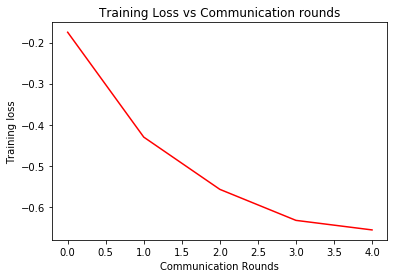

In [20]:
# PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

In [21]:
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>